Raw shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


EDA shape: (7043, 21)


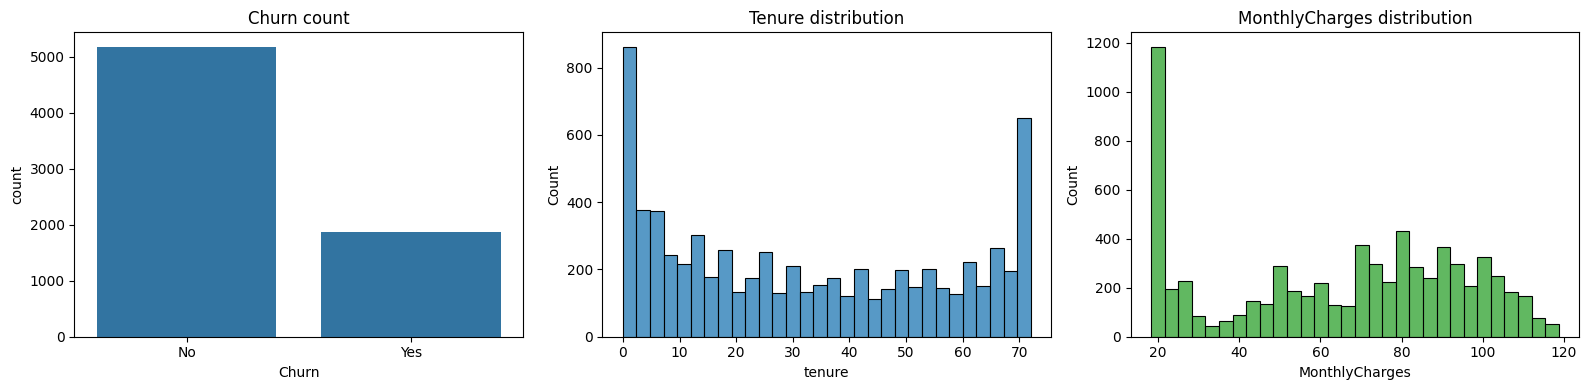


Churn rate by Contract:


,ChurnFlag
Contract,
Month-to-month,0.427
One year,0.113
Two year,0.028



Churn rate by InternetService:


,ChurnFlag
InternetService,
Fiber optic,0.419
DSL,0.190
No,0.074



Churn rate by PaymentMethod:


,ChurnFlag
PaymentMethod,
Electronic check,0.453
Mailed check,0.191
Bank transfer (automatic),0.167
Credit card (automatic),0.152



Churn rate by PaperlessBilling:


,ChurnFlag
PaperlessBilling,
Yes,0.336
No,0.163


Categorical: 15 | Numeric: 4
Logistic: acc=0.805 p=0.656 r=0.556 f1=0.602 auc=0.842
RandomForest: acc=0.786 p=0.624 r=0.484 f1=0.545 auc=0.826


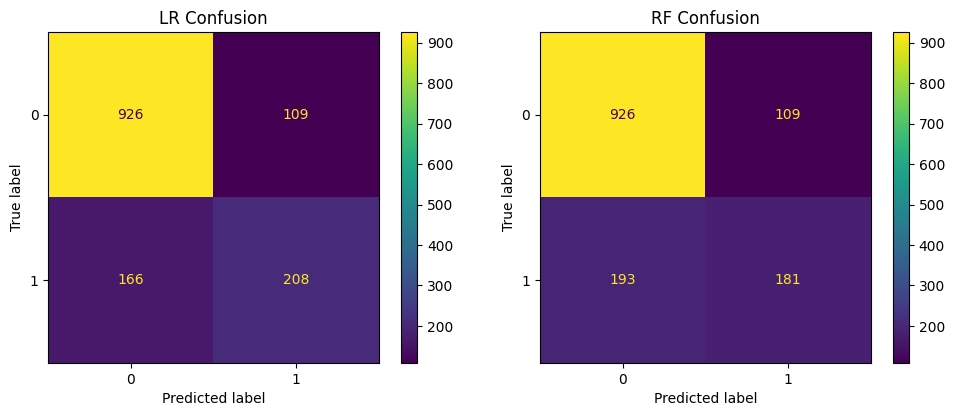

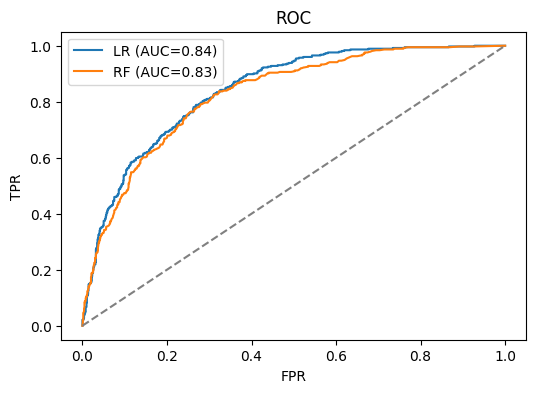

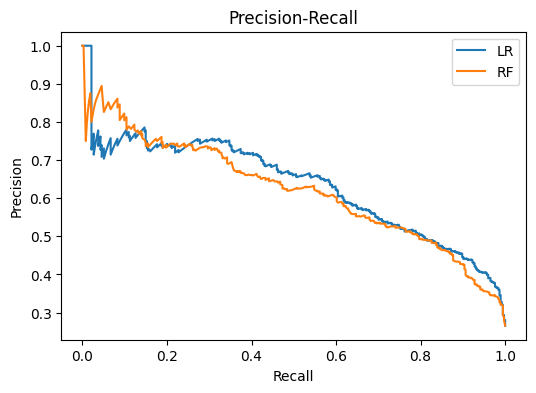

Top LR coefficients:


,feature,coef
21,Contract_Two year,-1.321104
27,tenure,-1.238468
6,InternetService_Fiber optic,1.168271
20,Contract_One year,-0.685157
29,TotalCharges,0.508781
28,MonthlyCharges,-0.446749
24,PaymentMethod_Electronic check,0.384967
22,PaperlessBilling_Yes,0.372556
17,StreamingTV_Yes,0.370658
19,StreamingMovies_Yes,0.368890


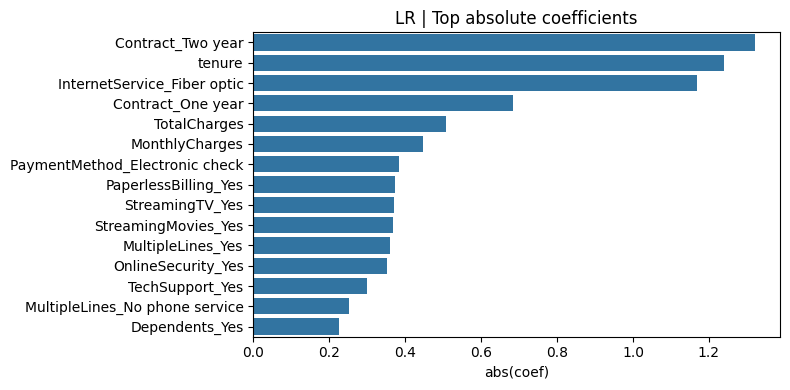

Top RF importances:


,feature,importance
29,TotalCharges,0.176945
27,tenure,0.165526
28,MonthlyCharges,0.151585
21,Contract_Two year,0.060689
6,InternetService_Fiber optic,0.043587
24,PaymentMethod_Electronic check,0.038548
20,Contract_One year,0.028746
9,OnlineSecurity_Yes,0.026563
0,gender_Male,0.025558
22,PaperlessBilling_Yes,0.024357


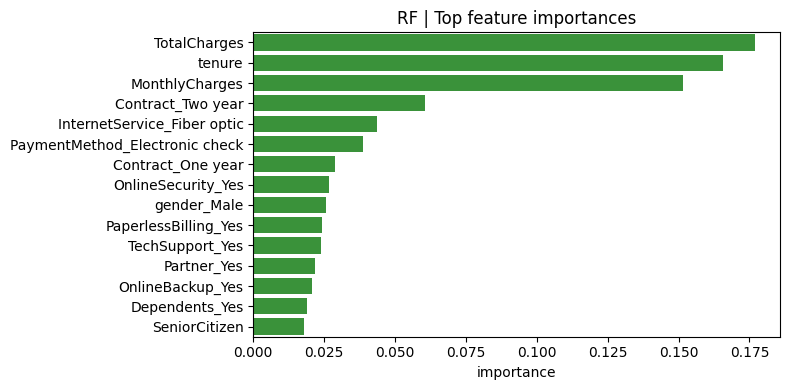

,threshold,accuracy,precision,recall,f1
3,0.25,0.736693,0.502547,0.791444,0.614746
4,0.30,0.753726,0.526419,0.719251,0.607910
5,0.35,0.769340,0.554324,0.668449,0.606061
2,0.20,0.706884,0.470765,0.839572,0.603266
6,0.40,0.779986,0.579602,0.622995,0.600515


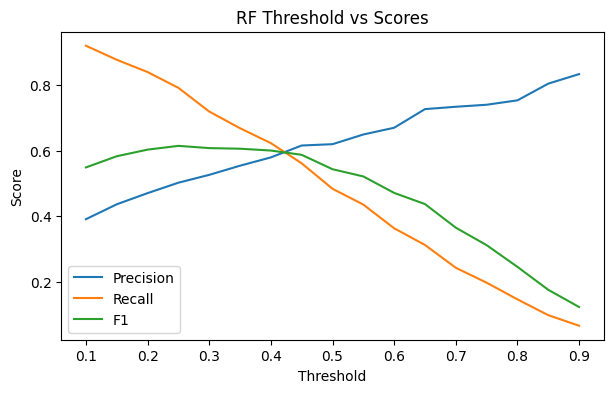

Predicted churn probability: 0.665 | Class: Churn
Saved: churn_rate.csv, lr_top_coeffs.csv, rf_top_features.csv, model_metrics.csv


In [ ]:
# =========================
# Telco Customer Churn: End-to-End
# =========================

# 0) Setup
!pip -q install scikit-learn==1.4.2 pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    roc_curve, precision_recall_curve, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RSEED = 42

# 1) Load
# Upload in Colab if needed:
# from google.colab import files
# uploaded = files.upload()

CSV_PATH = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df_raw = pd.read_csv(CSV_PATH)
print("Raw shape:", df_raw.shape)
display(df_raw.head())

# 2) Clean types and trim whitespace (prevents empty plots)
df = df_raw.copy()
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()

# Coerce TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace({'': np.nan}), errors='coerce')

# Keep EDA-safe frame (non-destructive)
eda = df.dropna(subset=['Churn', 'tenure', 'MonthlyCharges']).copy()
print("EDA shape:", eda.shape)

# 3) Quick EDA
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(x='Churn', data=eda, ax=axs[0])
axs[0].set_title('Churn count')

sns.histplot(eda['tenure'], bins=30, ax=axs[1], color='tab:blue')
axs[1].set_title('Tenure distribution')

sns.histplot(eda['MonthlyCharges'], bins=30, ax=axs[2], color='tab:green')
axs[2].set_title('MonthlyCharges distribution')

plt.tight_layout(); plt.show()

# Churn by key categorical segments
for col in ['Contract', 'InternetService', 'PaymentMethod', 'PaperlessBilling']:
    if col in eda.columns:
        tmp = eda.copy()
        tmp['ChurnFlag'] = tmp['Churn'].map({'Yes':1, 'No':0})
        print(f"\nChurn rate by {col}:")
        display(tmp.groupby(col)['ChurnFlag'].mean().sort_values(ascending=False).round(3))

# 4) Prepare data for modeling
mod = df.copy()
if 'customerID' in mod.columns:
    mod = mod.drop(columns=['customerID'])

# Map target
mod['Churn'] = mod['Churn'].map({'Yes':1, 'No':0})

# Ensure numerics are numeric
for c in ['TotalCharges', 'MonthlyCharges', 'tenure']:
    if c in mod.columns:
        mod[c] = pd.to_numeric(mod[c], errors='coerce')

# Minimal numeric imputation (median) to keep all rows
num_cols_all = mod.select_dtypes(include=[np.number]).columns.tolist()
for c in ['TotalCharges', 'MonthlyCharges', 'tenure']:
    if c in mod.columns:
        mod[c] = mod[c].fillna(mod[c].median())

# Split
y = mod['Churn']
X = mod.drop(columns=['Churn'])

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
print("Categorical:", len(cat_cols), "| Numeric:", len(num_cols))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RSEED
)

# 5) Preprocessing and models
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
        ('num', 'passthrough', num_cols),
    ],
    remainder='drop'
)

# Logistic Regression with scaling on numerics
preprocess_lr = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
        ('num', Pipeline([('sc', StandardScaler(with_mean=False))]), num_cols),
    ]
)

pipe_lr = Pipeline(steps=[
    ('prep', preprocess_lr),
    ('clf', LogisticRegression(max_iter=3000, n_jobs=-1))
])

pipe_rf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=400, random_state=RSEED, n_jobs=-1,
        class_weight='balanced_subsample'
    ))
])

# 6) Train
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# 7) Evaluate
def evaluate(model, X_te, y_te, name="model"):
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:,1]
    acc = accuracy_score(y_te, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_te, y_pred, average='binary', zero_division=0)
    auc = roc_auc_score(y_te, y_prob)
    print(f"{name}: acc={acc:.3f} p={p:.3f} r={r:.3f} f1={f1:.3f} auc={auc:.3f}")
    return {'name':name, 'acc':acc, 'prec':p, 'rec':r, 'f1':f1, 'auc':auc, 'y_prob':y_prob, 'y_pred':y_pred}

res_lr = evaluate(pipe_lr, X_test, y_test, "Logistic")
res_rf = evaluate(pipe_rf, X_test, y_test, "RandomForest")

# Confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, res_lr['y_pred'], ax=ax[0]); ax[0].set_title('LR Confusion')
ConfusionMatrixDisplay.from_predictions(y_test, res_rf['y_pred'], ax=ax[1]); ax[1].set_title('RF Confusion')
plt.tight_layout(); plt.show()

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, res_lr['y_prob'])
fpr_rf, tpr_rf, _ = roc_curve(y_test, res_rf['y_prob'])
plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={res_lr['auc']:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={res_rf['auc']:.2f})")
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend(); plt.show()

# PR curves
prec_lr, rec_lr, _ = precision_recall_curve(y_test, res_lr['y_prob'])
prec_rf, rec_rf, _ = precision_recall_curve(y_test, res_rf['y_prob'])
plt.figure(figsize=(6,4))
plt.plot(rec_lr, prec_lr, label='LR')
plt.plot(rec_rf, prec_rf, label='RF')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall'); plt.legend(); plt.show()

# 8) Feature names after OneHot (for explainability)
# Use LR pipeline to get aligned names
ohe = pipe_lr.named_steps['prep'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)
num_features = np.array(num_cols)
feature_names = np.concatenate([cat_features, num_features])

# Coefficients (LR)
lr_coefs = pipe_lr.named_steps['clf'].coef_[0]
coef_df = pd.DataFrame({'feature': feature_names, 'coef': lr_coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).head(15)
print("Top LR coefficients:")
display(coef_df[['feature','coef']])

plt.figure(figsize=(8,4))
sns.barplot(x='abs_coef', y='feature', data=coef_df, color='tab:blue')
plt.title('LR | Top absolute coefficients'); plt.xlabel('abs(coef)'); plt.ylabel('')
plt.tight_layout(); plt.show()

# Importances (RF)
# Need feature names from RF pipeline as well (same OneHot as 'preprocess')
ohe_rf = pipe_rf.named_steps['prep'].named_transformers_['cat']
cat_features_rf = ohe_rf.get_feature_names_out(cat_cols)
feature_names_rf = np.concatenate([cat_features_rf, num_features])

rf_clf = pipe_rf.named_steps['clf']
imp_df = pd.DataFrame({'feature': feature_names_rf, 'importance': rf_clf.feature_importances_})
imp_df = imp_df.sort_values('importance', ascending=False).head(15)
print("Top RF importances:")
display(imp_df)

plt.figure(figsize=(8,4))
sns.barplot(x='importance', y='feature', data=imp_df, color='tab:green')
plt.title('RF | Top feature importances'); plt.xlabel('importance'); plt.ylabel('')
plt.tight_layout(); plt.show()

# 9) Threshold tuning for RF
y_prob = res_rf['y_prob']
ths = np.linspace(0.1, 0.9, 17)
rows = []
for t in ths:
    pred_t = (y_prob >= t).astype(int)
    acc = accuracy_score(y_test, pred_t)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred_t, average='binary', zero_division=0)
    rows.append((t, acc, p, r, f1))
thr_df = pd.DataFrame(rows, columns=['threshold','accuracy','precision','recall','f1']).sort_values('f1', ascending=False)
display(thr_df.head(5))

plt.figure(figsize=(7,4))
plt.plot(ths, [x for x in pd.DataFrame(rows)[2]], label='Precision')
plt.plot(ths, [x for x in pd.DataFrame(rows)[3]], label='Recall')
plt.plot(ths, [x for x in pd.DataFrame(rows)[4]], label='F1')
plt.xlabel('Threshold'); plt.ylabel('Score'); plt.title('RF Threshold vs Scores'); plt.legend(); plt.show()

# 10) Predict on a new customer
sample = {
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 5,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 70.0,
    'TotalCharges': 350.0
}
new_df = pd.DataFrame([sample])
prob = pipe_rf.predict_proba(new_df)[0,1]
pred = int(prob >= 0.5)
print(f"Predicted churn probability: {prob:.3f} | Class: {'Churn' if pred==1 else 'No Churn'}")

# 11) Save artifacts
pd.DataFrame({'churn_rate':[df['Churn'].map({'Yes':1,'No':0}).mean()]}).to_csv('churn_rate.csv', index=False)
coef_df.to_csv('lr_top_coeffs.csv', index=False)
imp_df.to_csv('rf_top_features.csv', index=False)
pd.DataFrame([
    ['Logistic', res_lr['acc'], res_lr['prec'], res_lr['rec'], res_lr['f1'], res_lr['auc']],
    ['RandomForest', res_rf['acc'], res_rf['prec'], res_rf['rec'], res_rf['f1'], res_rf['auc']]
], columns=['model','accuracy','precision','recall','f1','roc_auc']).to_csv('model_metrics.csv', index=False)

print("Saved: churn_rate.csv, lr_top_coeffs.csv, rf_top_features.csv, model_metrics.csv")


In [ ]:
!pip -q install scikit-learn==1.4.2 pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    roc_curve, precision_recall_curve, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RSEED = 42


In [ ]:
CSV_PATH = "WA_Fn-UseC_-Telco-Customer-Churn.csv"  # ensure exact filename
df_raw = pd.read_csv(CSV_PATH)
print("Raw shape:", df_raw.shape)
display(df_raw.head())


Raw shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df = df_raw.copy()
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace({'': np.nan}), errors='coerce')


In [ ]:
eda = df.dropna(subset=['Churn','tenure','MonthlyCharges']).copy()
print("EDA shape:", eda.shape)


EDA shape: (7043, 21)


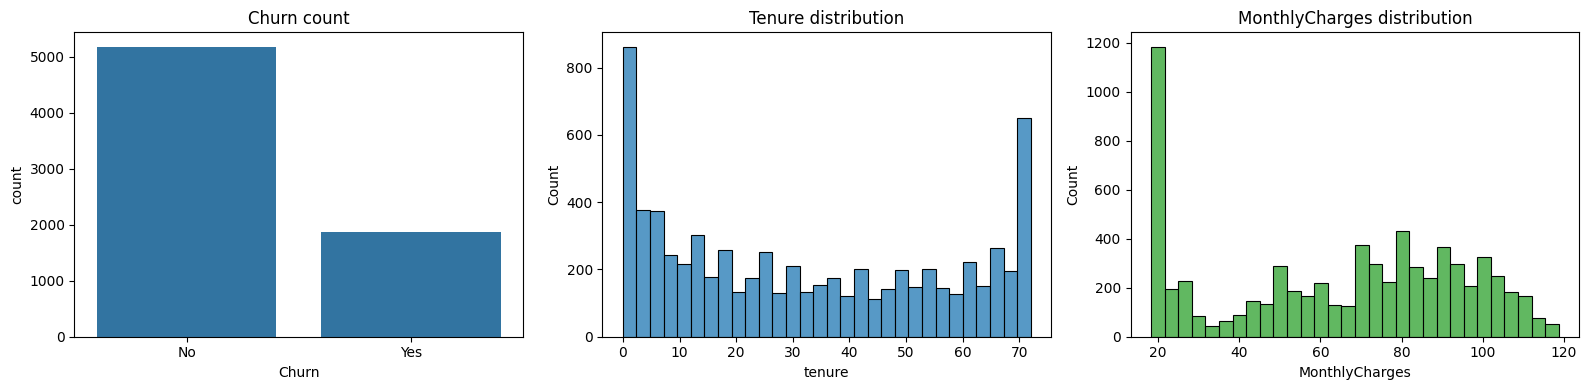


Churn rate by Contract:


,ChurnFlag
Contract,
Month-to-month,0.427
One year,0.113
Two year,0.028



Churn rate by InternetService:


,ChurnFlag
InternetService,
Fiber optic,0.419
DSL,0.190
No,0.074



Churn rate by PaymentMethod:


,ChurnFlag
PaymentMethod,
Electronic check,0.453
Mailed check,0.191
Bank transfer (automatic),0.167
Credit card (automatic),0.152



Churn rate by PaperlessBilling:


,ChurnFlag
PaperlessBilling,
Yes,0.336
No,0.163


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(x='Churn', data=eda, ax=axs[0]); axs[0].set_title('Churn count')
sns.histplot(eda['tenure'], bins=30, ax=axs[1], color='tab:blue'); axs[1].set_title('Tenure distribution')
sns.histplot(eda['MonthlyCharges'], bins=30, ax=axs[2], color='tab:green'); axs[2].set_title('MonthlyCharges distribution')
plt.tight_layout(); plt.show()

for col in ['Contract','InternetService','PaymentMethod','PaperlessBilling']:
    if col in eda.columns:
        tmp = eda.copy()
        tmp['ChurnFlag'] = tmp['Churn'].map({'Yes':1,'No':0})
        print(f"\nChurn rate by {col}:")
        display(tmp.groupby(col)['ChurnFlag'].mean().sort_values(ascending=False).round(3))


In [ ]:
mod = df.copy()
if 'customerID' in mod.columns:
    mod = mod.drop(columns=['customerID'])

mod['Churn'] = mod['Churn'].map({'Yes':1,'No':0})
for c in ['TotalCharges','MonthlyCharges','tenure']:
    mod[c] = pd.to_numeric(mod[c], errors='coerce')


In [ ]:
for c in ['TotalCharges','MonthlyCharges','tenure']:
    mod[c] = mod[c].fillna(mod[c].median())

y = mod['Churn']
X = mod.drop(columns=['Churn'])

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
print("Categorical:", len(cat_cols), "| Numeric:", len(num_cols))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RSEED
)


Categorical: 15 | Numeric: 4


In [ ]:
for c in ['TotalCharges','MonthlyCharges','tenure']:
    mod[c] = mod[c].fillna(mod[c].median())

y = mod['Churn']
X = mod.drop(columns=['Churn'])

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
print("Categorical:", len(cat_cols), "| Numeric:", len(num_cols))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RSEED
)


Categorical: 15 | Numeric: 4


In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
        ('num', 'passthrough', num_cols),
    ],
    remainder='drop'
)

preprocess_lr = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
        ('num', Pipeline([('sc', StandardScaler(with_mean=False))]), num_cols),
    ]
)

pipe_lr = Pipeline(steps=[
    ('prep', preprocess_lr),
    ('clf', LogisticRegression(max_iter=3000, n_jobs=-1))
])

pipe_rf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=400, random_state=RSEED, n_jobs=-1,
        class_weight='balanced_subsample'
    ))
])


Logistic: acc=0.805 p=0.656 r=0.556 f1=0.602 auc=0.842
RandomForest: acc=0.786 p=0.624 r=0.484 f1=0.545 auc=0.826


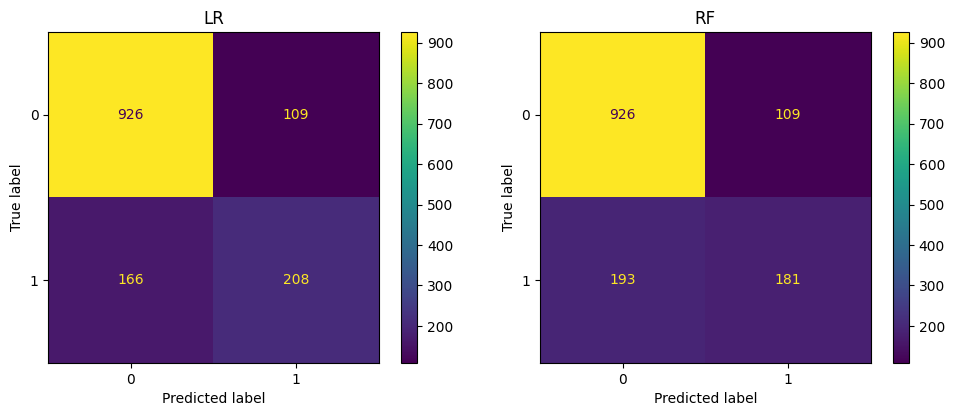

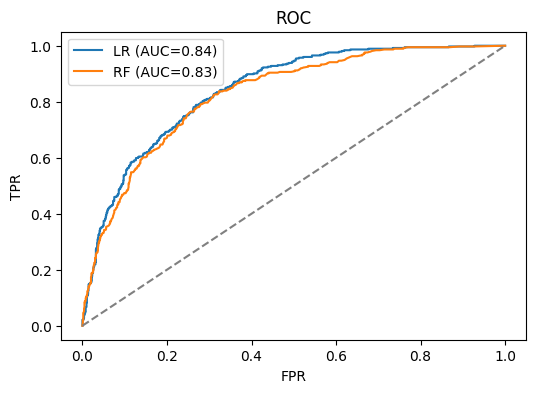

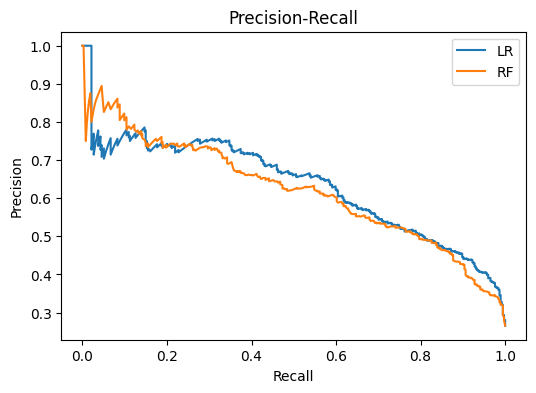

In [ ]:
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

def evaluate(model, X_te, y_te, name="model"):
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:,1]
    acc = accuracy_score(y_te, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_te, y_pred, average='binary', zero_division=0)
    auc = roc_auc_score(y_te, y_prob)
    print(f"{name}: acc={acc:.3f} p={p:.3f} r={r:.3f} f1={f1:.3f} auc={auc:.3f}")
    return {'name':name,'acc':acc,'prec':p,'rec':r,'f1':f1,'auc':auc,'y_prob':y_prob,'y_pred':y_pred}

res_lr = evaluate(pipe_lr, X_test, y_test, "Logistic")
res_rf = evaluate(pipe_rf, X_test, y_test, "RandomForest")

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, res_lr['y_pred'], ax=ax[0]); ax[0].set_title('LR')
ConfusionMatrixDisplay.from_predictions(y_test, res_rf['y_pred'], ax=ax[1]); ax[1].set_title('RF')
plt.tight_layout(); plt.show()

fpr_lr, tpr_lr, _ = roc_curve(y_test, res_lr['y_prob'])
fpr_rf, tpr_rf, _ = roc_curve(y_test, res_rf['y_prob'])
plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={res_lr['auc']:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={res_rf['auc']:.2f})")
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend(); plt.show()

prec_lr, rec_lr, _ = precision_recall_curve(y_test, res_lr['y_prob'])
prec_rf, rec_rf, _ = precision_recall_curve(y_test, res_rf['y_prob'])
plt.figure(figsize=(6,4))
plt.plot(rec_lr, prec_lr, label='LR')
plt.plot(rec_rf, prec_rf, label='RF')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall'); plt.legend(); plt.show()


,feature,coef
21,Contract_Two year,-1.321104
27,tenure,-1.238468
6,InternetService_Fiber optic,1.168271
20,Contract_One year,-0.685157
29,TotalCharges,0.508781
28,MonthlyCharges,-0.446749
24,PaymentMethod_Electronic check,0.384967
22,PaperlessBilling_Yes,0.372556
17,StreamingTV_Yes,0.370658
19,StreamingMovies_Yes,0.368890


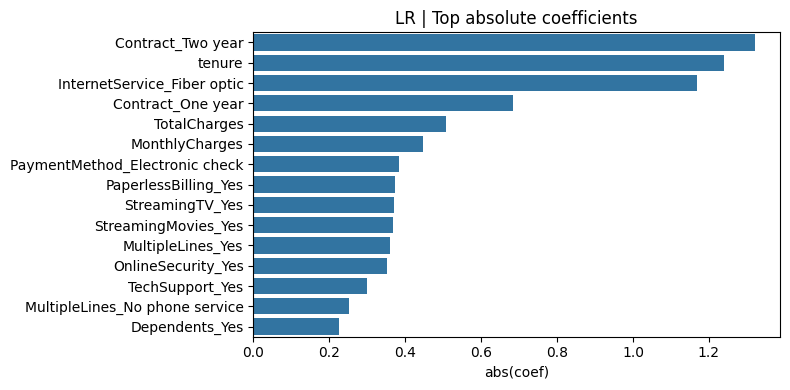

,feature,importance
29,TotalCharges,0.176945
27,tenure,0.165526
28,MonthlyCharges,0.151585
21,Contract_Two year,0.060689
6,InternetService_Fiber optic,0.043587
24,PaymentMethod_Electronic check,0.038548
20,Contract_One year,0.028746
9,OnlineSecurity_Yes,0.026563
0,gender_Male,0.025558
22,PaperlessBilling_Yes,0.024357


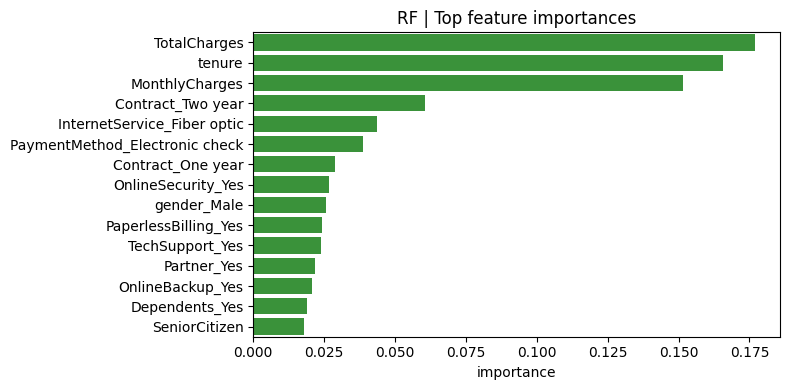

In [ ]:
# LR coefficients
ohe = pipe_lr.named_steps['prep'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)
num_features = np.array(num_cols)
feature_names = np.concatenate([cat_features, num_features])

lr_coefs = pipe_lr.named_steps['clf'].coef_[0]
coef_df = pd.DataFrame({'feature': feature_names, 'coef': lr_coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).head(15)
display(coef_df[['feature','coef']])

plt.figure(figsize=(8,4))
sns.barplot(x='abs_coef', y='feature', data=coef_df, color='tab:blue')
plt.title('LR | Top absolute coefficients'); plt.xlabel('abs(coef)'); plt.ylabel('')
plt.tight_layout(); plt.show()

# RF importances
ohe_rf = pipe_rf.named_steps['prep'].named_transformers_['cat']
cat_features_rf = ohe_rf.get_feature_names_out(cat_cols)
feature_names_rf = np.concatenate([cat_features_rf, num_features])

rf_clf = pipe_rf.named_steps['clf']
imp_df = pd.DataFrame({'feature': feature_names_rf, 'importance': rf_clf.feature_importances_})
imp_df = imp_df.sort_values('importance', ascending=False).head(15)
display(imp_df)

plt.figure(figsize=(8,4))
sns.barplot(x='importance', y='feature', data=imp_df, color='tab:green')
plt.title('RF | Top feature importances'); plt.xlabel('importance'); plt.ylabel('')
plt.tight_layout(); plt.show()


In [ ]:
# Threshold tuning for RF
y_prob = res_rf['y_prob']
ths = np.linspace(0.1, 0.9, 17)
rows = []
for t in ths:
    pred_t = (y_prob >= t).astype(int)
    acc = accuracy_score(y_test, pred_t)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred_t, average='binary', zero_division=0)
    rows.append((t, acc, p, r, f1))
thr_df = pd.DataFrame(rows, columns=['threshold','accuracy','precision','recall','f1']).sort_values('f1', ascending=False)
display(thr_df.head(5))

# Demo prediction
sample = {
    'gender': 'Male','SeniorCitizen': 0,'Partner': 'Yes','Dependents': 'No','tenure': 5,
    'PhoneService': 'Yes','MultipleLines': 'No','InternetService': 'Fiber optic',
    'OnlineSecurity': 'No','OnlineBackup': 'Yes','DeviceProtection': 'No','TechSupport': 'No',
    'StreamingTV': 'Yes','StreamingMovies': 'Yes','Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes','PaymentMethod': 'Electronic check','MonthlyCharges': 70.0,'TotalCharges': 350.0
}
prob = pipe_rf.predict_proba(pd.DataFrame([sample]))[0,1]
print(f"Predicted churn probability: {prob:.3f} | Class: {'Churn' if prob>=0.5 else 'No Churn'}")

# Exports
pd.DataFrame({'churn_rate':[df['Churn'].map({'Yes':1,'No':0}).mean()]}).to_csv('churn_rate.csv', index=False)
coef_df.to_csv('lr_top_coeffs.csv', index=False)
imp_df.to_csv('rf_top_features.csv', index=False)
pd.DataFrame([
    ['Logistic', res_lr['acc'], res_lr['prec'], res_lr['rec'], res_lr['f1'], res_lr['auc']],
    ['RandomForest', res_rf['acc'], res_rf['prec'], res_rf['rec'], res_rf['f1'], res_rf['auc']]
], columns=['model','accuracy','precision','recall','f1','roc_auc']).to_csv('model_metrics.csv', index=False)

print("Saved: churn_rate.csv, lr_top_coeffs.csv, rf_top_features.csv, model_metrics.csv")


,threshold,accuracy,precision,recall,f1
3,0.25,0.736693,0.502547,0.791444,0.614746
4,0.30,0.753726,0.526419,0.719251,0.607910
5,0.35,0.769340,0.554324,0.668449,0.606061
2,0.20,0.706884,0.470765,0.839572,0.603266
6,0.40,0.779986,0.579602,0.622995,0.600515


Predicted churn probability: 0.665 | Class: Churn
Saved: churn_rate.csv, lr_top_coeffs.csv, rf_top_features.csv, model_metrics.csv


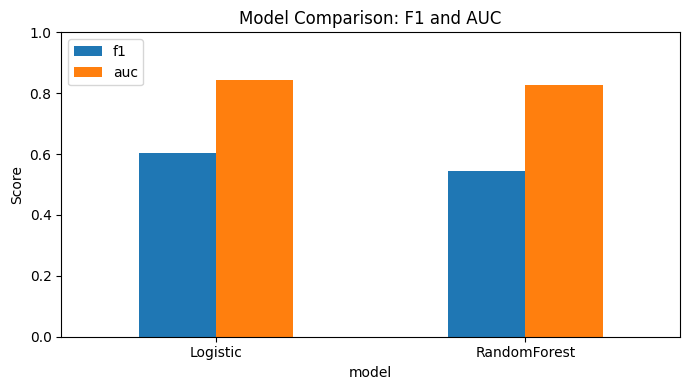

## Model comparison table

| model        |   accuracy |   precision |   recall |    f1 |   auc |
|:-------------|-----------:|------------:|---------:|------:|------:|
| Logistic     |      0.805 |       0.656 |    0.556 | 0.602 | 0.842 |
| RandomForest |      0.786 |       0.624 |    0.484 | 0.545 | 0.826 |

In [ ]:
# Bar chart: F1 and AUC
import pandas as pd
metrics_df = pd.DataFrame([
    ['Logistic',    res_lr['acc'], res_lr['prec'], res_lr['rec'], res_lr['f1'], res_lr['auc']],
    ['RandomForest',res_rf['acc'], res_rf['prec'], res_rf['rec'], res_rf['f1'], res_rf['auc']]
], columns=['model','accuracy','precision','recall','f1','auc']).set_index('model')

ax = metrics_df[['f1','auc']].plot(kind='bar', figsize=(7,4))
ax.set_title('Model Comparison: F1 and AUC')
ax.set_ylabel('Score'); ax.set_ylim(0,1.0); ax.legend(title='')
plt.xticks(rotation=0); plt.tight_layout(); plt.show()

# Neat Markdown-style table for notebooks
from IPython.display import display, Markdown
table_md = metrics_df.round(3).to_markdown()
display(Markdown("## Model comparison table"))
display(Markdown(table_md))